In [8]:
#import important libaries and illustris library

%matplotlib inline
import illustris_python as il
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import random

In [10]:
# Import Illustris data, specifying file path and snap

basePath = '/Users/alex/Illustris/Illustris-1'
snap = 135
#gpc_fields = ['GroupMass','GroupCM']
#gpc_data = il.groupcat.loadHalos(basePath,snap,fields=gpc_fields)
#gpc_pos_data = gpc_data['GroupCM']
#gpc_mass_data = np.expand_dims(gpc_data['GroupMass'], 0)
#gpc_joined_data = np.concatenate((gpc_pos_data, gpc_mass_data.T), axis=1)
#print gpc_joined_data, gpc_joined_data.shape

In [19]:
# Load data to be used:
# Define data fields, load these data fields into arrays and concatenate arrays into simple matrix

subhalo_fields = ['SubhaloCM', 'SubhaloMass']
fields = ['SubhaloMass','SubhaloSFRinRad']
subhalos = il.groupcat.loadSubhalos(basePath,135,fields=fields)
subhalo_data = il.groupcat.loadSubhalos(basePath,135,fields=subhalo_fields)

print subhalo_data['SubhaloCM'].shape, subhalo_data['SubhaloMass'].shape
print subhalo_data['SubhaloMass']
subhalo_joined_data = np.concatenate((subhalo_data['SubhaloCM'], np.expand_dims(subhalo_data['SubhaloMass'], 0).T), axis=1)

In [109]:
# Save illustris data in survey_ascii format, to be used with DisPerSE

np.savetxt("/Users/alex/Documents/Research/Astro/vm_share1/il_1_snap_135_posdata.txt",subhalo_joined_data, header="px,py,pz,m", fmt='%f,%f,%f,%f')

In [3]:
#create cutoff of illustris data (i.e. smaller universe box) and output data to be used for DisPerSE

In [20]:
# make_mask function takes position data, the index of the column to start the position data and three size contraints and gives out mask that is within the s1-3 box

# input: data: array 3 columns with x,y,z position
#        pos_start: first column index of position data in arrray
#        s1-3: box cutoff numbers

# output: binary mask with 1 or 0 for position whether it is in s1,s2,s3 or not

def make_mask(data, pos_start, s1, s2, s3):
    #create mask to constrain positions to within s1,s2,s3
    mask=((data[:,pos_start] > 0) & (data[:,pos_start] < s1) & (data[:,pos_start+1] > 0) & (data[:,pos_start+1] < s2) & (data[:,pos_start+2] < s3) & (data[:,pos_start+2] > 0)) 
    
    #create maskvalue, which has either 0 or 1, depending on whether position is in mask or not
    maskval=np.arange(0,data.size/data.shape[1])[mask]
    
    #return values that are within the s1-3 limit
    data_mask = data[maskval,:]
    return data_mask

In [21]:
#cut of data accorging to mask of limited size
size = 75000
subhalo_joined_data_mask = make_mask(subhalo_joined_data, 0, size, size, 0.25*size)

In [11]:
# Save data in survey_ascii format, to be used with DisPerSE

np.savetxt('/Users/alex/Desktop/Astro/vm_share1/il_1_snap_135_subhalo_mask_75k75k19k.txt', subhalo_joined_data_mask[:,0:3], delimiter =' ', header = 'px py pz')

In [54]:
#
# load DisPerSE data and use it
#

In [128]:
#
# putting everything in units of h! (the inital file is) (h= 0.7)
#

#load data of citical points and segments 

crits_file = './data/disperse/il_1_snap_135_subhalo_mask_75k75k19k.txt.NDnet_s5.97.up.NDskl.S500.BRK.ASMB.a.crits.txt'
crits_pos = np.loadtxt(crits_file, comments='#')[:,0:3]/0.7

segs_file = './data/disperse/il_1_snap_135_subhalo_mask_75k75k19k.txt.NDnet_s5.97.up.NDskl.S500.BRK.ASMB.a.segs.txt'
segs_pos = np.loadtxt(segs_file, comments='#')[:,0:3]/0.7
#print crits_pos, segs_pos, crits_pos.shape, segs_pos.shape

In [129]:
#calulate distance to a point:

#input: subhalo_mask: position of particles in column matrix x,y,z position
#        fil_pos_mat: position of filaments in column matrix x,y,z position

#output: array: 1st column is index of filament row that is nearest to particle. 2nd column is absolute distance

def distance_function(subhalo_mask, fil_pos_mat):
    
    #initialize number of columns in input file and number of steps to print
    subhalo_mask_size = subhalo_mask.shape[0]
    steps = max((subhalo_mask_size)/4,1)
    
    # create distance matrix - 2 columns for data 
    distance_mat = np.zeros(((subhalo_mask_size), 2))
    
    # enter for-loop which goes over the size of the rows of the position matrix 
    for i in range(0, subhalo_mask_size):
        
        #calculate raw position difference for 1 particle with ALL filament positions
        min_array = fil_pos_mat - subhalo_mask[i,0:3]
        
        #calculate actual distance
        min_dis = np.sqrt( (min_array*min_array).sum(axis=1) )
        
        #find minimum - i.e. nearest filament to particle
        min_index = np.argmin(min_dis, axis=0)
        
        #for each particle give index of filament point that is nearest and it´s absolute distance
        distance_mat[i,0] = min_index     
        distance_mat[i,1] = min_dis[min_index]
        
        if (i%steps == 0):
            print "done with", i/steps *25,"%"

    # return the distance matrix
    return distance_mat

In [130]:
#calulate aligment of spin vector:

#input distance_mat: index of nearest segment point, distance, x,y,z of angular momentum vector) 
#       fil_pos_mat: column matrix x,y,z position

#output: array: 1st column is index of filament row that is nearest to particle. 2nd column is absolute distance, 
#                                              3rd is dot product of angular momentum vector with segment vector

def align_function(distance_mat, fil_pos_mat):
    
    #initialize number of columns in input file and number of steps to print
    distance_mat_size = distance_mat.shape[0]
    #steps = max((distance_mat_size)/4,1)
    
    #create align matrix - 3 columns for data 
    align_mat = np.zeros(((distance_mat_size), 3))
    
    # enter for-loop which goes over the size of the rows of the position matrix 
    for i in range(0, distance_mat_size):
        
        #calculate vector segment is pointing in (+1 from index in distance_mat to -1)
        fil_vec = fil_pos_mat[(distance_mat[i,0] +1),0:3] - fil_pos_mat[(distance_mat[i,0] -1),0:3]
        
        #get angular mom. vector of galaxy
        gal_vec = distance_mat[i,2:5]
        
        #calculate size
        fil_vec_size = np.sqrt( (fil_vec*fil_vec).sum(axis=0) )
        gal_vec_size = np.sqrt( (gal_vec*gal_vec).sum(axis=0) )
        
        align_mat[i,0] = distance_mat[i,0]
        align_mat[i,1] = distance_mat[i,1]
        
        align_mat[i,2] = abs(((fil_vec*gal_vec).sum(axis=0))/(fil_vec_size * gal_vec_size))

        #if (i%steps == 0):
         #   print "done with", i/steps *25,"%"

    # return the distance matrix 
    return align_mat

In [131]:
galaxy_file = './data/illustris/galaxyData_zeph_Il1_snap135.txt'

# 0:HaloNumber, 1:SubhaloNumber, 2:StellarMass, 3:GasMass, 4:DarkMatterMass, 5-7:SubhaloPosition x, SubhaloPosition y, SubhaloPosition z, 8-10:CoM Velocity x, CoM Velocity y, CoM Velocity z, 11-13:AngularMomentum x, AngularMomentum y, AngularMomentum z, 14:Kappa, 15:Flatness, 16:Ellip, 17:Lambda
galaxies = np.genfromtxt(galaxy_file, comments='#')

#print galaxy_pos[1,:]
# 
# -- old file way
#

#StellarMass, GasMass, DarkMatterMass, SubhaloPosition x, SubhaloPosition y, SubhaloPosition z, AngularMomentum x, AngularMomentum y, AngularMomentum z, Lambda, HaloNumber, SubhaloNumber, CoM Velocity x, CoM Velocity y, CoM Velocity z, Kappa, Flatness, Ellip
#galaxy_pos = galaxy_pos[:,[2,3,4,5,6,7,11,12,13,17,14]]

#put positions first
#SubhaloPosition x, SubhaloPosition y, SubhaloPosition z, StellarMass, GasMass, DarkMatterMass, AngularMomentum x, AngularMomentum y, AngularMomentum z, Lambda, Kappa
#galaxy_pos[:,[0,1,2,3,4,5,6,7,8,9,10]] = galaxy_pos[:,[4,5,6,0,1,2,3,7,8,9,10]]


In [145]:
#filter galaxy data through mask and compute distance

#
# putting everything in units of h! (the inital file is) (h= 0.7)
#

index_pos_data = 5
galaxy_pos_mask = make_mask(galaxies, index_pos_data, 75000/0.7, 75000/0.7, 0.19*75000/0.7)

galaxies_positions = galaxy_pos_mask[:,5:8]

galaxy_segs_distance_mat = distance_function(galaxies_positions, segs_pos)
galaxy_crits_distance_mat = distance_function(galaxies_positions, crits_pos)

done with 0 %
done with 25 %
done with 50 %
done with 75 %
done with 0 %
done with 25 %
done with 50 %
done with 75 %


13.0138116089


In [22]:
# add the output of the distance function to the end of the matrix
# 0:HaloNumber, 1:SubhaloNumber, 2:StellarMass, 3:GasMass, 4:DarkMatterMass, 5-7:SubhaloPosition x, SubhaloPosition y, SubhaloPosition z, 8-10:CoM Velocity x, CoM Velocity y, CoM Velocity z, 11-13:AngularMomentum x, AngularMomentum y, AngularMomentum z, 14:Kappa, 15:Flatness, 16:Ellip, 17:Lambda, 18: Index of nearest segment/critical point, 19:absolute distance from galaxy to nearest

galaxy_crits_joined = np.concatenate(( galaxy_pos_mask[:,:], galaxy_crits_distance_mat[:,:]),axis=1)

galaxy_segs_joined = np.concatenate(( galaxy_pos_mask[:,:], galaxy_segs_distance_mat[:,:]), axis=1)



# create matrix for align function input
galaxy_segs_vec = galaxy_segs_joined[:,[18,19,11,12,13]]

gal_align_segs = align_function(galaxy_segs_vec, segs_pos)

# 0:HaloNumber, 1:SubhaloNumber, 2:StellarMass, 3:GasMass, 4:DarkMatterMass, 5-7:SubhaloPosition x, SubhaloPosition y, SubhaloPosition z, 8-10:CoM Velocity x, CoM Velocity y, CoM Velocity z, 11-13:AngularMomentum x, AngularMomentum y, AngularMomentum z, 14:Kappa, 15:Flatness, 16:Ellip, 17:Lambda, 18: Index of nearest segment/critical point, 19:absolute distance from galaxy to nearest, 20:dot product of angular momentum vector with segment vector
galaxy_segs_data = np.concatenate((galaxy_segs_joined[:,:], gal_align_segs[:,2:3]), axis=1)
print galaxy_segs_data.shape

NameError: name 'galaxy_pos_mask' is not defined

In [23]:
np.savetxt('./data/galaxy_segments_data_v2.txt', galaxy_segs_data, delimiter =' ', header = '0:HaloNumber, 1:SubhaloNumber, 2:StellarMass, 3:GasMass, 4:DarkMatterMass, 5-7:SubhaloPosition x, SubhaloPosition y, SubhaloPosition z, 8-10:CoM Velocity x, CoM Velocity y, CoM Velocity z, 11-13:AngularMomentum x, AngularMomentum y, AngularMomentum z, 14:Kappa, 15:Flatness, 16:Ellip, 17:Lambda, 18: Index of nearest segment/critical point, 19:absolute distance from galaxy to nearest, 20:dot product of angular momentum vector with segment vector')

In [167]:
# Kappa kut-off
def kappa_cut(galaxy_data, kappa_index):
    
    #create mask to constrain kappa
    mask = ((galaxy_data[:,kappa_index]) > 0.5)
    
    #create maskvalue, which has either 0 or 1, depending on whether kappa is in mask or not
    maskval = np.arange(0,galaxy_data.size/galaxy_data.shape[1])[mask]
    
    #return values
    data_mask = galaxy_data[maskval,:]
    
    return data_mask

In [168]:
#Binning
def bin_data(bin_data, index1, index2, bins):
    
    data_pts = bins;
    data_steps = 1./bins;
    
    data = bin_data[:, [index1, index2]]

    binned_mat = np.zeros((data_pts, 4))
    
    amax = np.amax(data[:,0])
    
    for i in range (0, data_pts):
        
        
        mask_i = (((data[:,0]/amax) > (i*data_steps)) & ((data[:,0]/amax) < (data_steps*(i+1)) ))
        
        #create maskvalue, which has either 0 or 1, depending on whether position is in mask or not
        maskval_i = np.arange(0,data.size/data.shape[1])[mask_i]
        
        data_mask_i = data[maskval_i,:]
    
        binned_mat[i,0] = np.mean(data_mask_i[:,0])
        binned_mat[i,1] = np.mean(data_mask_i[:,1])
        binned_mat[i,2] = (np.std(data_mask_i[:,0]))/(np.sqrt(np.count_nonzero(data_mask_i[:,0])))
        binned_mat[i,3] = (np.std(data_mask_i[:,1]))/(np.sqrt(np.count_nonzero(data_mask_i[:,1])))

        
    return binned_mat


In [149]:

print galaxy_segs_data_kappa.shape

(273, 21)


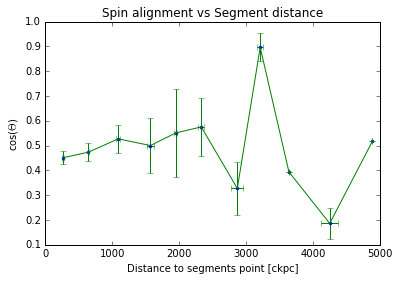

In [154]:
# 0:HaloNumber, 1:SubhaloNumber, 2:StellarMass, 3:GasMass, 4:DarkMatterMass, 5-7:SubhaloPosition x, SubhaloPosition y, SubhaloPosition z, 8-10:CoM Velocity x, CoM Velocity y, CoM Velocity z, 11-13:AngularMomentum x, AngularMomentum y, AngularMomentum z, 14:Kappa, 15:Flatness, 16:Ellip, 17:Lambda, 18: Index of nearest segment/critical point, 19:absolute distance from galaxy to nearest, 20:dot product of angular momentum vector with segment vector

galaxy_segs_data_kappa = kappa_cut(galaxy_segs_data, 14)
binned_data = bin_data(galaxy_segs_data_kappa, 19, 20, 15)

x = binned_data[:,0]
y = binned_data[:,1]

plt.plot( x, y,'.' );
plt.xscale('linear')
plt.yscale('linear')

plt.xlabel('Distance to segments point [ckpc]')
plt.ylabel('cos($\Theta$)')
plt.title('Spin alignment vs Segment distance')

plt.errorbar(x, y, xerr=binned_data[:,2], yerr=binned_data[:,3] )
plt.show()

In [171]:
print galaxy_segs_data_kappa[100,:], np.amax(galaxy_segs_data_kappa[:,2])

[  5.09000000e+02   3.49020000e+05   8.03067890e+00   1.34664220e+00
   3.55411440e+02   9.84681950e+04   3.54926180e+04   1.84296060e+04
   3.11990820e+02   1.65014440e+02   5.12246850e+02  -2.59980410e+02
   3.86200470e+02   9.50090880e+02   5.30723690e-01   4.41176470e-01
   4.54646110e-01   5.11362550e-01   4.48730000e+04   3.09616023e+02
   9.22676279e-01] 39.382536 131.00872


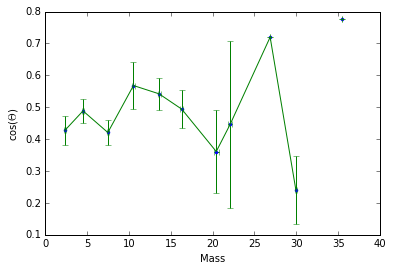

In [169]:
binned_data = bin_data(galaxy_segs_data_kappa, 2, 20, 13)

x = binned_data[:,0]
y = binned_data[:,1]

plt.plot( x, y,'.' );
plt.xscale('linear')
plt.yscale('linear')

plt.xlabel('Mass')
plt.ylabel('cos($\Theta$)')
#plt.title('Spin alignment vs Segment distance')

plt.errorbar(x, y, xerr=binned_data[:,2], yerr=binned_data[:,3] )
plt.show()

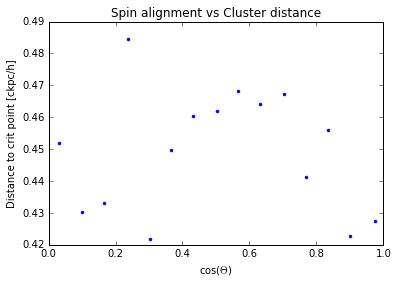

In [146]:
#plt.plot( critical_points_data[:,2], critical_points_data[:,4] ,'.' );
x = bin_data(segments_points_data)[:,0]
y = bin_data(segments_points_data)[:,3]

plt.plot( x, y,'.' );
plt.xscale('linear')
plt.yscale('linear')

plt.ylabel('Distance to crit point [ckpc/h]')
plt.xlabel('cos($\Theta$)')
plt.title('Spin alignment vs Cluster distance')

#plt.errorbar(x, y, xerr=0, yerr=bin_data(segments_points_data)[:,2] )
plt.show()

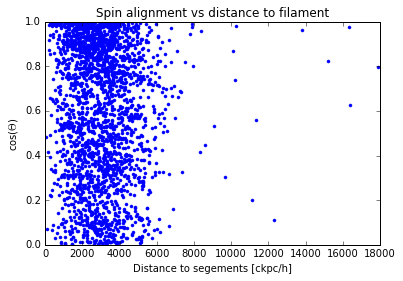

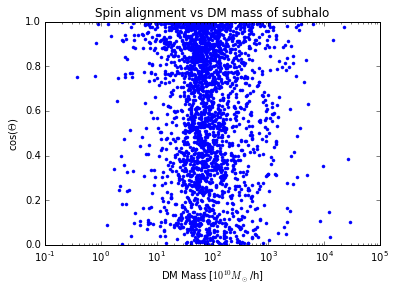

In [75]:
plt.plot(  galaxy_segs_joined_vec[:,1] , gal_align_segs[:,2],'.' );
plt.xscale('linear')
plt.yscale('linear')

plt.xlabel('Distance to segements [ckpc/h]')
plt.ylabel('cos($\Theta$)')
plt.title('Spin alignment vs distance to filament')
plt.show()

plt.plot( galaxy_segs_joined[:,7] ,  gal_align_segs[:,2],'.' );
plt.xscale('log')
plt.yscale('linear')

plt.xlabel('DM Mass [$10^{10}M_\odot$/h]')
plt.ylabel('cos($\Theta$)')
plt.title('Spin alignment vs DM mass of subhalo')
plt.show()

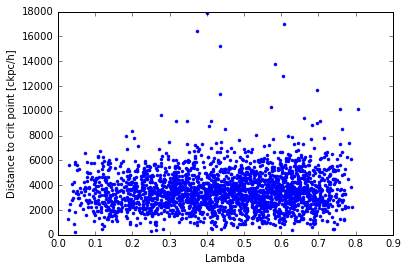

In [76]:

plt.plot(galaxy_crits_joined[:,11], galaxy_crits_joined[:,1],'.' );
plt.xscale('linear')
plt.yscale('linear')

plt.ylabel('Distance to crit point [ckpc/h]')
plt.xlabel('Lambda')
plt.show()

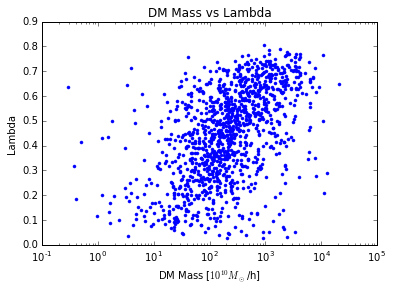

In [277]:
plt.plot( galaxy_crits_joined[:,9], galaxy_crits_joined[:,11], '.' );
plt.xscale('log')
plt.yscale('linear')

plt.xlabel('DM Mass [$10^{10}M_\odot$/h]')
plt.ylabel('Lambda')

plt.title('DM Mass vs Lambda')

plt.show()

In [74]:
segs_distance_mat = distance_function(subhalo_joined_data_mask, segs_pos)

KeyboardInterrupt: 

In [ ]:
plt.plot(segs_distance_mat[:,4], segs_distance_mat[:,3], '.' );
plt.xscale('log')
plt.yscale('log')

plt.ylabel('Distance to crit point [ckpc/h]')
plt.xlabel('Mass [10^10$M_\odot$/h]')
plt.show()

In [ ]:
segs_distance_mat

np.concatenate(galac_data[:,5:8],galac_data[:,11:14])
